# Search Liver Cancer Cures
# Stream twitter data into postgres database

In [1]:
%matplotlib inline

In [16]:
import tweepy
import pandas as pd
import os
import json
import requests
import re
import matplotlib.pyplot as plt
import psycopg2
from dateutil import parser

from wordcloud import WordCloud

### Authorize Twitter

In [3]:
consumer_key = os.environ["MF_TWITTER_CONSUMER_API_KEY"]
consumer_secret = os.environ["MF_TWITTER_CONSUMER_API_KEY_SECRET"]
access_token = os.environ["MF_TWITTER_ACCESS_TOKEN"]
access_token_secret = os.environ["MF_TWITTER_ACCESS_TOKEN_SECRET"]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

### Query Search API

In [4]:
query = 'liver cancer'
max_tweets = 100
r = [status for status in tweepy.Cursor(api.search, q=query, tweet_mode="extended").items(max_tweets)]

In [5]:
statuses = [status._json['full_text'] for status in r if 'retweeted_status' not in status._json]
statuses

['“The water is so contaminated that there have been at least 100 deaths due to liver cancer and other water-borne diseases in the last five years. The authorities have failed completely,” says Dharmendra Rathi of Gangnauli village in Baghpat\n#WorldWaterDay https://t.co/dxHDd0qQvQ',
 "@MaryKenny4 @DavQuinn Alcohol causes liver damage, sugar causes obesity, tobacco causes lung cancer, salt cause heart problems, what's your point?",
 'HBV-Related #Liver #Cancer and the Role of #aspirin #Gastroenterologistsconference #Gastroenterologycongress #Gastroenterologistsmeet @Gastro_meet #Gastroenterologistssummit #Gastroenterologistsevent https://t.co/ppgNQRGron https://t.co/GEU8BoUAjh',
 '武田邦彦 勝谷誠彦氏の死亡原因とアルコールと肝臓癌のウソ！\nhttps://t.co/ByNlcW6hD7 … https://t.co/LR6t01oW43',
 'Daily aspirin may reduce risk of hepatitis-related liver cancer https://t.co/dHsVkCgueJ',
 'Daily aspirin may reduce risk of hepatitis-related liver cancer https://t.co/qN2a2MOXFh',
 '@NYDailyNews Smoking will give mouth, thr

In [8]:
def format_status_list(status_list):
    status_list = [re.sub('RT @.+: ', '', status) for status in status_list]
    status_list = [re.sub('\n', ' ', status) for status in status_list]
    status_list = [re.sub('https?://[^ ]+', '', status) for status in status_list] # remove links
    status_list = [re.sub('@\w+', '', status) for status in status_list] # remove @
    return status_list

def filter_http(tokens):
    tokens = [word for word in tokens if re.match(r'https?.+', word) == None]
    tokens = [word for word in tokens if re.match(r'.+https?.+', word) == None]
    tokens = [word for word in tokens if re.match(r'.+twitter.+', word) == None]
    return tokens

def create_token_string(status_list):
    tokens = ','.join(status_list)
    tokens = tokens.replace("'", '')
    tokens = tokens.lower()
    
    return tokens

In [7]:
# Format statuses
statuses2 = format_status_list(statuses)
statuses2

['“The water is so contaminated that there have been at least 100 deaths due to liver cancer and other water-borne diseases in the last five years. The authorities have failed completely,” says Dharmendra Rathi of Gangnauli village in Baghpat #WorldWaterDay ',
 "  Alcohol causes liver damage, sugar causes obesity, tobacco causes lung cancer, salt cause heart problems, what's your point?",
 'HBV-Related #Liver #Cancer and the Role of #aspirin #Gastroenterologistsconference #Gastroenterologycongress #Gastroenterologistsmeet  #Gastroenterologistssummit #Gastroenterologistsevent  ',
 '武田邦彦 勝谷誠彦氏の死亡原因とアルコールと肝臓癌のウソ！  … ',
 'Daily aspirin may reduce risk of hepatitis-related liver cancer ',
 'Daily aspirin may reduce risk of hepatitis-related liver cancer ',
 ' Smoking will give mouth, throat and lung cancer. Drinking will ruin   liver and addiction could affect behavior. But weed maybe can make you psychotic.',
 "Want to know more about #aflatoxin discussed in 's last lecture? Interesting  a

In [9]:
# Create word cloud

def generate_wordcloud_image(token_string):

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
#                     stopwords = self.stopwords,
                    min_font_size = 10).generate(token_string)

    # Plot the WordCloud
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show();

In [10]:
# Turn list into a string of tokens for word cloud
token_string = create_token_string(statuses2)

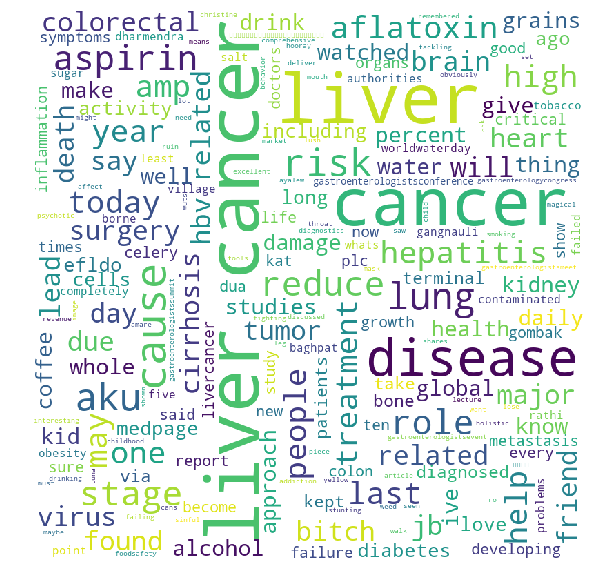

In [11]:
# generate word clouds
generate_wordcloud_image(token_string)

### Data filtering

We filter data to identify health tweets. Keyword filtering, which is used to obtain the data, is insufficient; e.g., “I'm sick of this” and “justin beber ur so cool and i have beber fever.” [8] Instead, we rely on supervised machine learning classification to filter tweets.

We filtered tweets from 2009–2010 with 20,000 keyphrases and randomly annotated a subset of the remaining 11.7 million tweets using Amazon Mechanical Turk, a crowdsourcing service, [30]–[31] to distinguish relevant health tweets from spurious matches. Workers annotated examples as positive (about the user’s health), negative (unrelated, e.g. news updates or advertisements, or not English), or ambiguous. To ensure quality, we annotated a sample ourselves and required workers to annotate some of these “gold” tweets, which allowed us to check annotator accuracy and exclude inaccurate workers. Second, each tweet was labeled by three annotators and the final label was determined by majority vote, removing the 1.1% of examples where the majority vote was ambiguous.

This yielded a set of 5,128 tweets (36.1% positive) for training data to create a classifier for health relevance. We trained a binary logistic regression model using the MALLET toolkit [32] with n-gram (1≤n≤3) word features. We tokenized the raw text such that contiguous blocks of punctuation were treated as word separators, with punctuation blocks retained as word tokens. We removed tweets containing URLs, which were almost always false positives.

We tuned the prediction threshold using 10-fold cross validation to result in an estimated 68% precision and 72% recall, a balance of precision and recall. Applying this classifier to the health stream yielded 144 million health tweets, a nearly hundred-fold increase over our earlier study of 1.6 million tweets. [24].

## Set up Database

In [ ]:
# Create table
Create table tweets (id INTEGER PRIMARY KEY, 
                     username VARCHAR(255),
                    created_at VARCHAR(45),
                    tweet TEXT,
                     retweet_count INTEGER,
                     location VARCHAR(100),
                     place VARCHAR(100)
                    );

In [29]:
## Connect to database

def connect(username, created_at, tweet, retweet_count, place , location):
    """ Connect to postgres database and insert Twitter data """

    try:
        conn = psycopg2.connect(host = 'localhost',
                                  dbname='medfact_db',
                                  user='root',
#                                   password = os.environ['DB_PASSWORD'],
#                                   charset = 'utf8',
                               )
        if conn.is_connected():
            """ Insert Twitter data """
            cursor = conn.cursor()
            #Twitter, fold
            query = "INSERT INTO Golf (username, created_at, tweet, retweet_count,place, location) VALUES (%s, %s, %s, %s, %s, %s)"
            cursor.execute(query, (username, created_at, tweet, retweet_count, place, location))
            conn.commit()
            
    except Exception as e:
        print('Unable to connect to database')
        print(e)
    
    cursor.close()
    conn.close()
    
    return

## Stream data from Twitter API

In [30]:
# Tweepy class to access Twitter API
class Streamlistener(tweepy.StreamListener):


    def on_connect(self):
        print("You are now connected to the Twitter API")


    def on_error(self):
        if status_code != 200:
            print("Error found")
            # Returning False disconnects the stream
            return False


    def on_data(self,data):
        """ This method reads in tweet data as Json and extracts the data we want. """
        
        try:
            raw_data = json.loads(data)

            if 'text' in raw_data:
                 
                username = raw_data['user']['screen_name']
                created_at = parser.parse(raw_data['created_at'])
                tweet = raw_data['text']
                retweet_count = raw_data['retweet_count']

                if raw_data['place'] is not None:
                    place = raw_data['place']['country']
                    print(place)
                else:
                    place = None
                

                location = raw_data['user']['location']

                #insert data just collected into Postgres database
                connect(username, created_at, tweet, retweet_count, place, location)
                print("Tweet colleted at: {} ".format(str(created_at)))
                
        except Exception as e:
            print(e)

## Put it all together

In [ ]:
# authentification so we can access twitter
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api =tweepy.API(auth, wait_on_rate_limit=True)
    
# create instance of Streamlistener
    listener = Streamlistener(api = api)
    stream = tweepy.Stream(auth, listener = listener)

    track = ['golf', 'masters', 'reed', 'mcilroy', 'woods']
    #track = ['nba', 'cavs', 'celtics', 'basketball']
    # choose what we want to filter by
    stream.filter(track = track, languages = ['en'])

You are now connected to the Twitter API
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable to connect to database
FATAL:  role "root" does not exist

local variable 'cursor' referenced before assignment
Unable 

## Keywords and search terms for liver cancer

In [ ]:
Hemangioma
Hepatic adenoma
Focal nodular hyperplasia
Cysts
Lipoma
Fibroma
Leiomyoma
Hepatocellular carcinoma (HCC)
hepatoma
Hepatic adenoma
Hamartoma
Hepatoma
Hepatic hemangiomas
Cholangiocarcinoma
Mixed tumours of the liver
Tumours of mesenchymal tissue
Sarcoma of liver
Hepatoblastoma in children
Infantile hemangioendothelialoma

selenium
vitamin a
vitamin b3
vitamin k
vitamin d
Interferon Alfa-2a
Roferon-A
Surgical resection
Radiography-guided radiofrequency ablation
Embolization of the tumour supplying artery
Transplantation
Etoposide
Toposar
VePesid
Etopos
Lastet
Vp-Tec
Chemotherapy
Hepatic arterial infusion
Hepatic arterial infusion pump
Chemoembolization
Radiation therapy
Surgery
Partial hepatectomy
Liver transplantation
Radiofrequency ablation
Laser therapy, microwave therapy
Percutaneous ethanol injection
Cryosurgery
Pain relief
Pain medications
Nerve block
Massage
Acupuncture
Acupressure
Relaxation techniques
Palliative therapy
Surgical resection
Surgery
Medications
Pain medications
See treatment of liver cancer
Surgery, liver transplant, percutaneous ethanol injection, radiofrequency ablation, transcatheter arterial chemoembolization, high intensity focused ultrasound, hormonal therapy, cryosurgery, palliative, chemotherapy, radiation
Surgical resection
Liver transplantation

The best prognosis for a cure for liver cancer occurs when it is diagnosed and treated in its very earliest stage. Treatment plans for liver cancer are individualized for each person's specific case. Treatment plans are based on the specific type and stage of advancement of the liver cancer, the condition of the liver, a person's medical history, generally health, age, coexisting diseases, and other factors. Treatment for liver cancer is delivered by a team of specialists in liver cancer care. These specialists can include medical oncologists, hepatologists, gastroenterologists, surgeons, oncology nurses, registered dietician, and radiation oncologists.

Treatment for early stage liver cancer that has not spread outside the liver may include liver transplant in which the cancerous liver is removed and replaced by a healthly donor liver. A successful liver transplant can cure liver cancer. Another option for early stage liver cancer is the removal of the tumor and surrounding tissue. This is called a partial hepatectomy.

If liver cancer has grown to a more advanced stage or if these surgeries are not an option, other treatments may include chemotherapy, radiation therapy, or cryosurgery. Cryosurgery uses a metal probe to freeze and kill the cancer cells. Other possible treatments include ethanol injection, in which alcohol is injected into the liver to kill cancer cells. A treatment called radiofrequency ablation uses a probe to kill the cancer cells with heat.

It may also be recommended that a person with liver cancer enroll in a clinical trial of new therapies and treatments for liver cancer.

For people whose liver cancer has metastasized and has become terminal, the goals of treatment may change. Treatment may shifts away from curing the disease and focuses on measures to keep a person comfortable and maximize the quality of life. This treatment is administered through a hospice program.

Cholangiocarcinoma
Primary liver cancer (hepatocellular carcinoma) tends to occur in livers damaged by birth defects, alcohol abuse, or chronic infection with diseases such as hepatitis B and C, hemochromatosis (a hereditary disease associated with too much iron in the liver), and cirrhosis. More than half of all people diagnosed with primary liver cancer have cirrhosis -- a scarring condition of the liver commonly caused by alcohol abuse. Hepatitis B and C and hemochromatosis can cause permanent damage and liver failure. Liver cancer may also be linked to obesity and fatty liver disease.

Various cancer-causing substances are associated with primary liver cancer, including certain herbicides and chemicals such as vinyl chloride and arsenic. Smoking, especially if you abuse alcohol as well, also increases risk. Aflatoxins, cancer-causing substances made by a type of plant mold, have also been implicated. Aflatoxins can contaminate wheat, peanuts, rice, corn, and soybeans. These are rare problems in most developed countries like the U.S. Other causes include the hormones androgen and estrogen and a dye formerly used in medical tests called thorotrast.